# seperate LR for segmentation and classification

In [11]:
(1)
# Data Processing and Visualization
import os
import random
import glob
import re
import imgaug.augmenters as iaa
from tifffile import TiffFile

# Data Manipulation and Analysis
import numpy as np
import pandas as pd
import math
import imgaug.augmenters as iaa  # For mild data augmentation

# Image Processing and Visualization
import matplotlib.pyplot as plt
import cv2
from skimage import io
from PIL import Image
# Deep Learning Framework (TensorFlow/Keras)
import tensorflow as tf

# Specific TensorFlow/Keras Components
from tensorflow.keras import optimizers
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, BatchNormalization, Activation, GlobalAveragePooling2D, Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau, 
    EarlyStopping, 
    ModelCheckpoint,
    CSVLogger, 
    LearningRateScheduler
)

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
import tensorflow.keras.backend as K

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, normalize
from IPython.display import display
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.losses import binary_crossentropy


Datamap imports the path of images and store them to a variable

In [12]:
(2)
datamap = []
error_files = []

# Specify the path to your dataset on your Windows machine
dataset_path = "Seg_MRI"

# Iterate over subdirectories in the specified path
for sub_dir_path in glob.glob(dataset_path + "/*"):
    # Check if the current path is a directory
    if os.path.isdir(sub_dir_path):
        # Extract the tumor type from the directory name
        dir_name = os.path.basename(sub_dir_path)

        # Iterate over files in the directory
        for filename in os.listdir(sub_dir_path):
            # Construct the full path to the image file
            image_path = os.path.join(sub_dir_path, filename)
            
            # Attempt to load the image
            try:
                # Check if the file is a TIFF file
                if image_path.lower().endswith('.tiff') or image_path.lower().endswith('.tif'):
                    try:
                        with TiffFile(image_path) as tif:
                            # Add the TIFF file to the datamap
                            datamap.append({
                                'tumor_type': dir_name,
                                'file_name': filename,
                                'file_path': image_path,
                                'image': tif.asarray()
                            })
                    except TiffFileError as e:
                        # Add the full file path and error message to the list of error files
                        error_files.append((image_path, str(e)))
                else:
                    # Load non-TIFF image formats using OpenCV
                    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                    
                    # Check if the image is successfully loaded
                    if image is not None:
                        # Append a dictionary to the datamap
                        datamap.append({
                            'tumor_type': dir_name,
                            'file_name': filename,
                            'file_path': image_path,  # Include the full file path
                            'image': image
                        })
                    else:
                        # Add the full file path to the list of error files
                        error_files.append(image_path)
            except Exception as e:
                # Add the full file path and error message to the list of error files
                error_files.append((image_path, str(e)))

# Display the datamap
for entry in datamap[:10]:  # Display only the first 10 entries
    print(f"Tumor Type: {entry['tumor_type']}, File Name: {entry['file_name']}, File Path: {entry['file_path']}, Image Shape: {entry['image'].shape}")

# Display the list of error files
print("\nError Files:")
for error in error_files:
    if isinstance(error, tuple):
        print(f"Error loading file '{error[0]}': {error[1]}")
    else:
        print(f"Error loading file '{error}'")


Tumor Type: Glioblastoma, File Name: 39_flair.tif, File Path: Seg_MRI/Glioblastoma/39_flair.tif, Image Shape: (240, 240)
Tumor Type: Glioblastoma, File Name: 149_flair_mask.tif, File Path: Seg_MRI/Glioblastoma/149_flair_mask.tif, Image Shape: (240, 240)
Tumor Type: Glioblastoma, File Name: 138_flair_mask.tif, File Path: Seg_MRI/Glioblastoma/138_flair_mask.tif, Image Shape: (240, 240)
Tumor Type: Glioblastoma, File Name: 146_flair_mask.tif, File Path: Seg_MRI/Glioblastoma/146_flair_mask.tif, Image Shape: (240, 240)
Tumor Type: Glioblastoma, File Name: 137_flair_mask.tif, File Path: Seg_MRI/Glioblastoma/137_flair_mask.tif, Image Shape: (240, 240)
Tumor Type: Glioblastoma, File Name: 21_flair.tif, File Path: Seg_MRI/Glioblastoma/21_flair.tif, Image Shape: (240, 240)
Tumor Type: Glioblastoma, File Name: 149_flair.tif, File Path: Seg_MRI/Glioblastoma/149_flair.tif, Image Shape: (240, 240)
Tumor Type: Glioblastoma, File Name: 155_flair.tif, File Path: Seg_MRI/Glioblastoma/155_flair.tif, Imag

Coverting the datamap to dataframe

In [13]:
(3)
# Convert the data_map to a pandas DataFrame
datamap_df = pd.DataFrame(datamap)
print(datamap_df.head())
print(datamap_df.tail())
# print(datamap_df)

     tumor_type           file_name                                file_path  \
0  Glioblastoma        39_flair.tif        Seg_MRI/Glioblastoma/39_flair.tif   
1  Glioblastoma  149_flair_mask.tif  Seg_MRI/Glioblastoma/149_flair_mask.tif   
2  Glioblastoma  138_flair_mask.tif  Seg_MRI/Glioblastoma/138_flair_mask.tif   
3  Glioblastoma  146_flair_mask.tif  Seg_MRI/Glioblastoma/146_flair_mask.tif   
4  Glioblastoma  137_flair_mask.tif  Seg_MRI/Glioblastoma/137_flair_mask.tif   

                                               image  
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
     tumor_type      file_name                      file_path  \
4599    Gliomas   743_mask.tif   Seg_MRI/Gliomas/743_mask.tif   
4600    Gliomas    23_mask.tif    Seg_MRI/Gliomas/23_mask.t

In [14]:
(4)
# Filtering image paths and mask paths
df_imgs = datamap_df[~datamap_df['file_path'].str.contains("mask")]
df_masks = datamap_df[datamap_df['file_path'].str.contains("mask")]

# Creating a dictionary for mask paths with tumor type
mask_dict = {path[:-9]: (path, tumor_type) for path, tumor_type in zip(df_masks["file_path"].values, df_masks["tumor_type"].values)}

# Pairing each image with its corresponding mask and tumor type
pairs = []
for image_path, tumor_type in zip(df_imgs["file_path"].values, df_imgs["tumor_type"].values):
    base_path = image_path[:-4]  # Remove the '.tif' extension
    mask_info = mask_dict.get(base_path)  # Retrieve the corresponding mask path and tumor type
    if mask_info:
        mask_path, mask_tumor_type = mask_info
        # Ensure the tumor type matches for both image and mask
        if tumor_type == mask_tumor_type:
            pairs.append({'Tumor_Type': tumor_type, 'Image_Path': image_path, 'Mask_Path': mask_path})

# Convert pairs list to DataFrame
pairs_df = pd.DataFrame(pairs)

# Sort the DataFrame by 'Tumor Type'
final_df = pairs_df.sort_values(by='Tumor_Type').reset_index(drop=True)

# Display the updated DataFrame
print(final_df.head())  # Shows the first few rows


     Tumor_Type                          Image_Path  \
0  Glioblastoma   Seg_MRI/Glioblastoma/39_flair.tif   
1  Glioblastoma   Seg_MRI/Glioblastoma/94_flair.tif   
2  Glioblastoma   Seg_MRI/Glioblastoma/43_flair.tif   
3  Glioblastoma  Seg_MRI/Glioblastoma/118_flair.tif   
4  Glioblastoma   Seg_MRI/Glioblastoma/99_flair.tif   

                                 Mask_Path  
0   Seg_MRI/Glioblastoma/39_flair_mask.tif  
1   Seg_MRI/Glioblastoma/94_flair_mask.tif  
2   Seg_MRI/Glioblastoma/43_flair_mask.tif  
3  Seg_MRI/Glioblastoma/118_flair_mask.tif  
4   Seg_MRI/Glioblastoma/99_flair_mask.tif  


In [15]:
final_df

,Tumor_Type,Image_Path,Mask_Path
0,Glioblastoma,Seg_MRI/Glioblastoma/39_flair.tif,Seg_MRI/Glioblastoma/39_flair_mask.tif
1,Glioblastoma,Seg_MRI/Glioblastoma/94_flair.tif,Seg_MRI/Glioblastoma/94_flair_mask.tif
2,Glioblastoma,Seg_MRI/Glioblastoma/43_flair.tif,Seg_MRI/Glioblastoma/43_flair_mask.tif
3,Glioblastoma,Seg_MRI/Glioblastoma/118_flair.tif,Seg_MRI/Glioblastoma/118_flair_mask.tif
4,Glioblastoma,Seg_MRI/Glioblastoma/99_flair.tif,Seg_MRI/Glioblastoma/99_flair_mask.tif
...,...,...,...
2239,Neurocytoma,Seg_MRI/Neurocytoma/115.tif,Seg_MRI/Neurocytoma/115_mask.tif
2240,Neurocytoma,Seg_MRI/Neurocytoma/T2_0.tif,Seg_MRI/Neurocytoma/T2_0_mask.tif
2241,Neurocytoma,Seg_MRI/Neurocytoma/T2_52.tif,Seg_MRI/Neurocytoma/T2_52_mask.tif
2242,Neurocytoma,Seg_MRI/Neurocytoma/20.tif,Seg_MRI/Neurocytoma/20_mask.tif


Displaying the images with mask

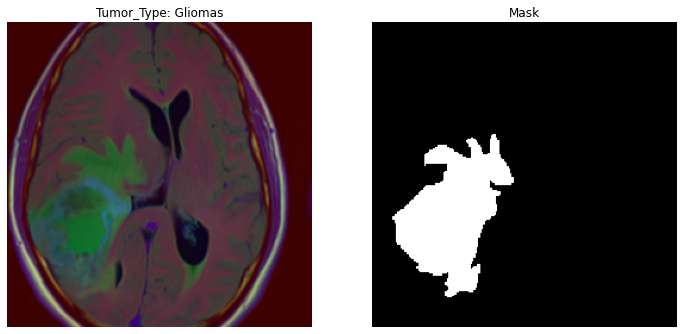

In [16]:
(5)
# Randomly select a pair
idx = random.randint(0, len(final_df) - 1)
selected_row = final_df.iloc[idx]

# Paths
img_path = selected_row['Image_Path']
mask_path = selected_row['Mask_Path']
tumor_type = selected_row['Tumor_Type']

# Load the image and mask
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask in grayscale

# Display the image, mask, and tumor type
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title(f'Tumor_Type: {tumor_type}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.show()


Display with Mask overlay

ValueError: shape mismatch: value array of shape (3,) could not be broadcast to indexing result of shape (3801,4)

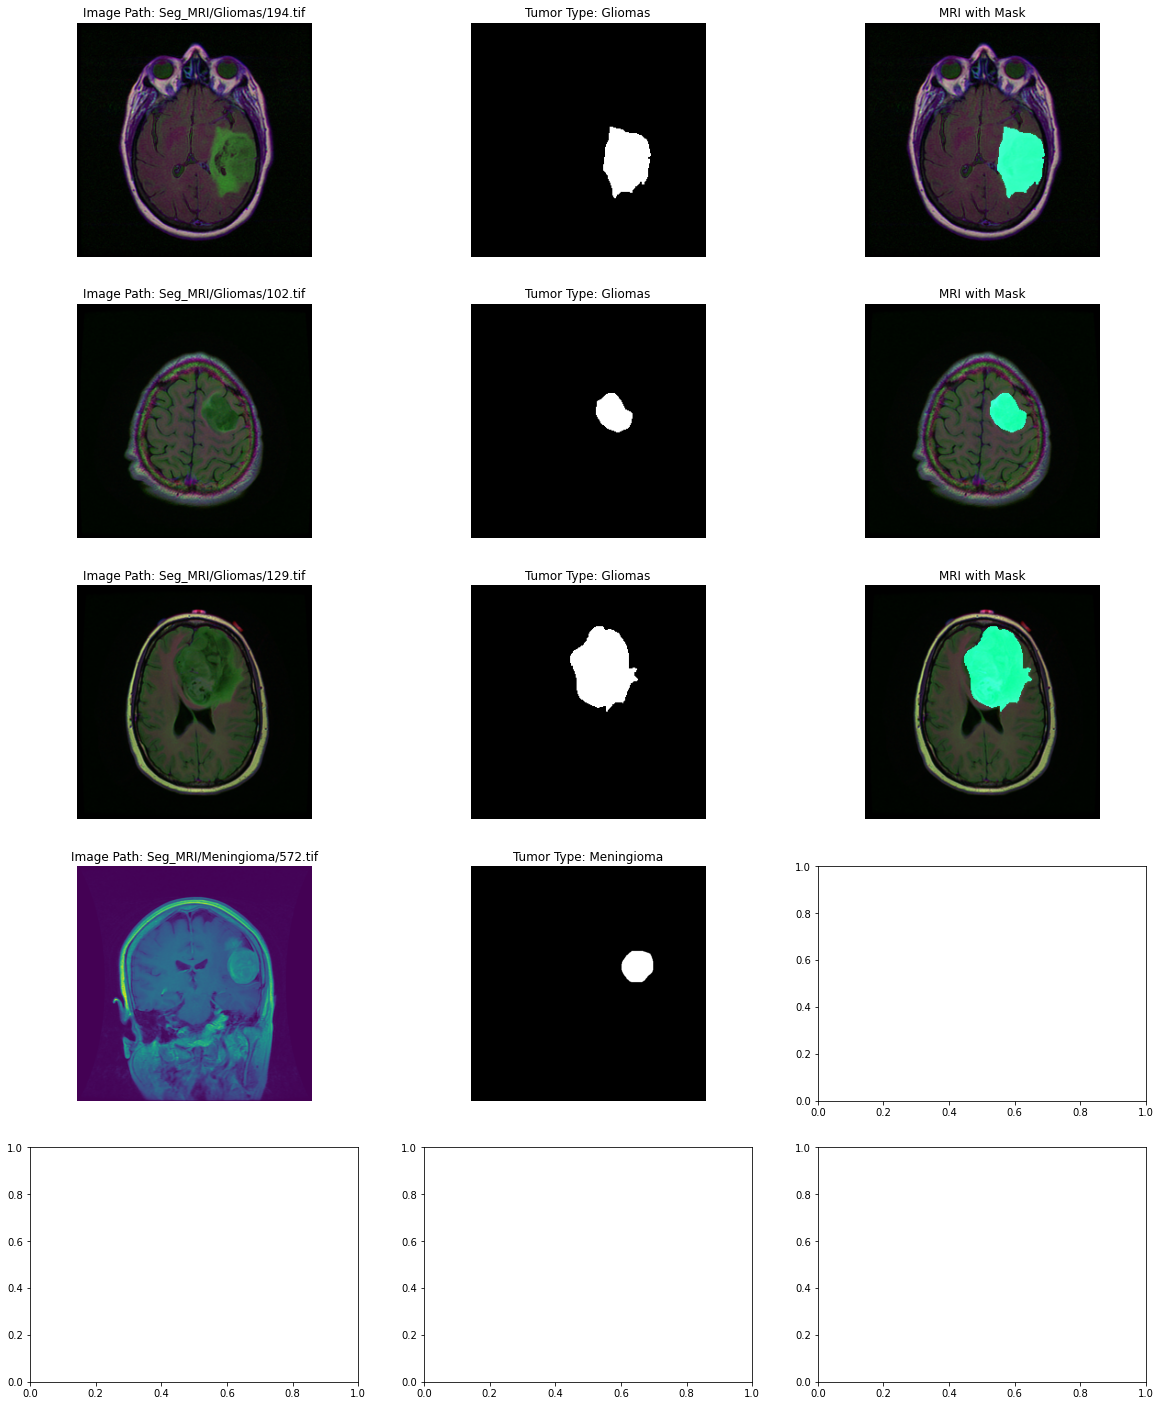

In [21]:
(6)
# Randomly select up to 5 unique indices from the DataFrame
num_samples = min(len(final_df), 5)
random_indices = random.sample(range(len(final_df)), num_samples)

# Initialize the figure for plotting
fig, axs = plt.subplots(num_samples, 3, figsize=(20, num_samples * 5))  # Adjust rows to num_samples

# Iterate through the randomly selected indices
for count, idx in enumerate(random_indices):
    row = final_df.iloc[idx]
    
    # Load the mask image
    mask_path = row.get('Mask_Path')
    if not mask_path or not os.path.exists(mask_path):
        print(f"Error: Mask image path '{mask_path}' not found.")
        continue
    
    mask = io.imread(mask_path)
    if mask is None:
        print(f"Error loading mask image '{mask_path}'.")
        continue
    
    # Threshold the mask image to make it binary
    mask_binary = (mask > 0).astype(np.uint8) * 255  # Thresholding to make it binary
    
    # Load the brain MRI image
    img_path = row.get('Image_Path')
    if not img_path or not os.path.exists(img_path):
        print(f"Error: Image path '{img_path}' not found.")
        continue
    
    try:
        img = io.imread(img_path)
        if img is None:
            print(f"Error loading image '{img_path}'.")
            continue
    except Exception as e:
        print(f"Error loading image '{img_path}': {e}")
        continue
    
    # Display the brain MRI
    axs[count][0].imshow(img, cmap='gray')  # Display in grayscale
    axs[count][0].set_title(f"Image Path: {img_path}")
    axs[count][0].axis('off')

    # Display the mask
    axs[count][1].imshow(mask_binary, cmap='gray')  # Use the binary mask
    axs[count][1].set_title(f"Tumor Type: {row.get('Tumor_Type')}")
    axs[count][1].axis('off')

    # Overlay the mask on the brain MRI
    overlay_color = [0, 255, 150]  # Specify overlay color
    overlay_mask = np.zeros_like(img)
    overlay_mask[mask_binary == 255] = overlay_color  # Set overlay color where binary mask is present
    img_overlay = np.clip(img.astype(np.int16) + overlay_mask, 0, 255).astype(np.uint8)  # Apply overlay to image while ensuring valid pixel values
    axs[count][2].imshow(img_overlay)
    axs[count][2].set_title("MRI with Mask")
    axs[count][2].axis('off')

# Adjust layout
fig.tight_layout()
plt.show()

Labeling Tumor Types

In [22]:
(7)
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and return encoded labels
final_df['Tumor_Type_Int'] = label_encoder.fit_transform(final_df['Tumor_Type'])

# Now, 'Tumor Type Int' column contains the integer labels for the tumor types
print(final_df[['Tumor_Type', 'Tumor_Type_Int']].head())


     Tumor_Type  Tumor_Type_Int
0  Glioblastoma               0
1  Glioblastoma               0
2  Glioblastoma               0
3  Glioblastoma               0
4  Glioblastoma               0


In [23]:
(8)
# inverse mapping from integer labels back to original string labels
inverse_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}

# Get unique encoded labels from 'Tumor_Type_Int' column
unique_encoded_labels = final_df['Tumor_Type_Int'].unique()

# Sort the unique labels to ensure they are in ascending order
unique_encoded_labels.sort()

# Display each unique encoded label and its corresponding original tumor type
for encoded_label in unique_encoded_labels:
    original_label = inverse_mapping[encoded_label]
    print(f"Encoded Label: {encoded_label}, Original Tumor Type: {original_label}")


Encoded Label: 0, Original Tumor Type: Glioblastoma
Encoded Label: 1, Original Tumor Type: Gliomas
Encoded Label: 2, Original Tumor Type: Meningioma
Encoded Label: 3, Original Tumor Type: Neurocytoma


In [24]:
(9)
# Adding a new column 'Original_Tumor_Type' to final_df that maps 'Tumor_Type_Int' back to the original string labels
final_df['Original_Tumor_Type'] = final_df['Tumor_Type_Int'].map(inverse_mapping)

# Now, 'final_df' contains a new column 'Original_Tumor_Type' with the original string labels
print(final_df[['Tumor_Type_Int', 'Original_Tumor_Type']].head())


   Tumor_Type_Int Original_Tumor_Type
0               0        Glioblastoma
1               0        Glioblastoma
2               0        Glioblastoma
3               0        Glioblastoma
4               0        Glioblastoma


In [ ]:
final_df

# Split data into training, testing, validation

In [26]:
(10)
# Split the main dataset into training and a temporary test set with 15% of the data
X_train, X_temp_test = train_test_split(final_df, test_size=0.15, random_state=42)

# Split the temporary test set into validation and test sets equally
X_val, X_test = train_test_split(X_temp_test, test_size=0.5, random_state=42)

# Display the sizes of each dataset
print(f"Train size is {len(X_train)}, validation size is {len(X_val)}, & test size is {len(X_test)}")

# Extract 'Image_Path' and 'Mask_Path' for training, validation, and test datasets
train_ids = list(X_train['Image_Path'])
train_masks = list(X_train['Mask_Path'])

val_ids = list(X_val['Image_Path'])
val_masks = list(X_val['Mask_Path'])

test_ids = list(X_test['Image_Path'])
test_masks = list(X_test['Mask_Path'])


Train size is 1230, validation size is 109, & test size is 109


# Data Generator

In [27]:
(11)
class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, labels, batch_size, image_size, shuffle=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.image_paths))

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        batch_indices = self.indexes[start_idx:end_idx]

        images, masks = [], []
        labels = np.empty((len(batch_indices),), dtype=int)

        for i, idx in enumerate(batch_indices):
            image_path = self.image_paths[idx]
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, self.image_size)
            image = image / 255.0  # Normalize images
            images.append(np.expand_dims(image, axis=-1))  # Add channel dimension for grayscale

            mask_path = self.mask_paths[idx]
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, self.image_size)
            mask = np.expand_dims(mask / 255.0, axis=-1)  # Normalize and add channel dimension
            masks.append(mask)

            labels[i] = self.labels[idx]

        images = np.array(images, dtype="float32")
        masks = np.array(masks, dtype="float32")
        
        return images, {'segmentation_output': masks, 'classification_output': labels}    

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_indices):
        images = np.empty((len(batch_indices), *self.image_size, 3))
        masks = np.empty((len(batch_indices), *self.image_size, 1))
        labels = np.empty((len(batch_indices)), dtype=int)
        
        for i, idx in enumerate(batch_indices):
            img_path = self.image_paths[idx]
            mask_path = self.mask_paths[idx]
            
            image = cv2.imread(img_path)
            image = cv2.resize(image, self.image_size)
            images[i,] = image / 255.0
            
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, self.image_size)
            masks[i,:,:,0] = mask / 255.0
            
            labels[i] = self.labels[idx]
        
        return images, masks, labels

# Assuming X_train, X_val are DataFrames with appropriate columns
train_generator = CustomDataGenerator(
    image_paths=X_train['Image_Path'].tolist(),
    mask_paths=X_train['Mask_Path'].tolist(),
    labels=X_train['Tumor_Type_Int'].tolist(),
    batch_size=16,
    image_size=(256, 256),
    shuffle=True
)

val_generator = CustomDataGenerator(
    image_paths=X_val['Image_Path'].tolist(),
    mask_paths=X_val['Mask_Path'].tolist(),
    labels=X_val['Tumor_Type_Int'].tolist(),
    batch_size=16,
    image_size=(256, 256),
    shuffle=False
)


Visuals of Preprocessing

In [28]:
batch_index = 0  # or any valid index within the range of available batches

# Fetch batch data
X_batch, outputs_batch = train_generator.__getitem__(batch_index)

# Extract masks and labels from the outputs dictionary
masks_batch = outputs_batch['segmentation_output']
labels_batch = outputs_batch['classification_output']

print("Labels:", labels_batch)



Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


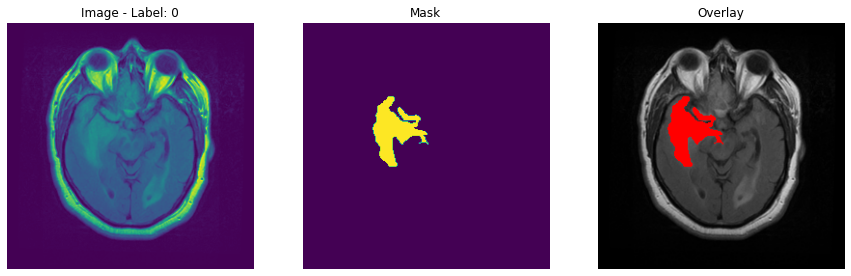

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


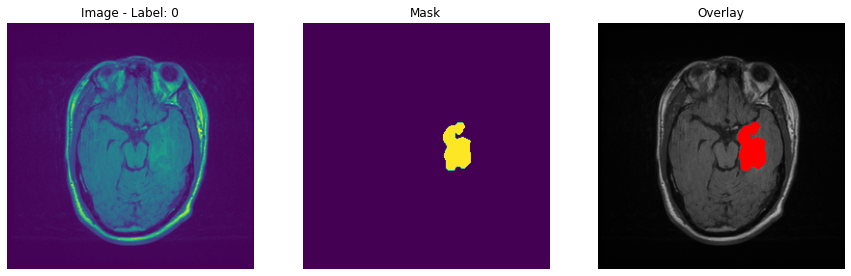

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


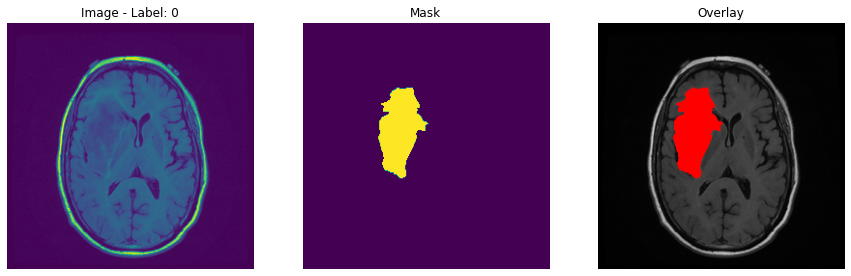

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


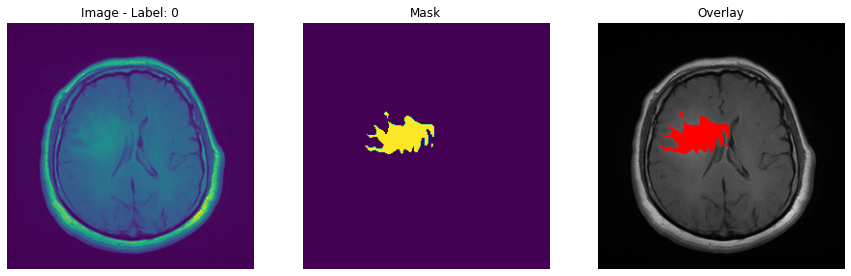

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


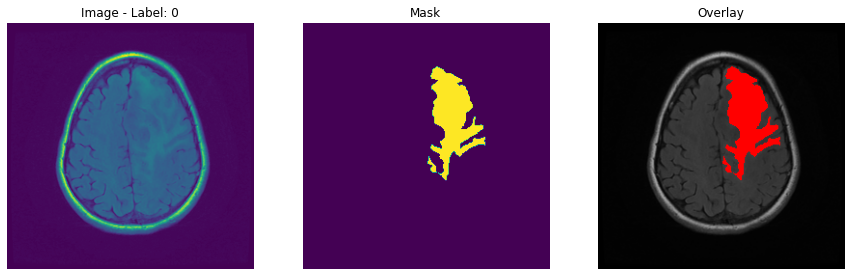

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


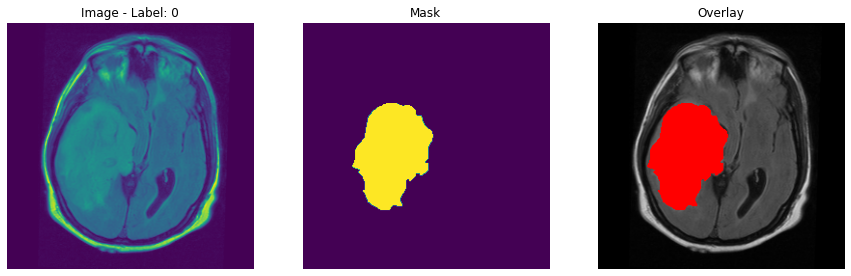

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


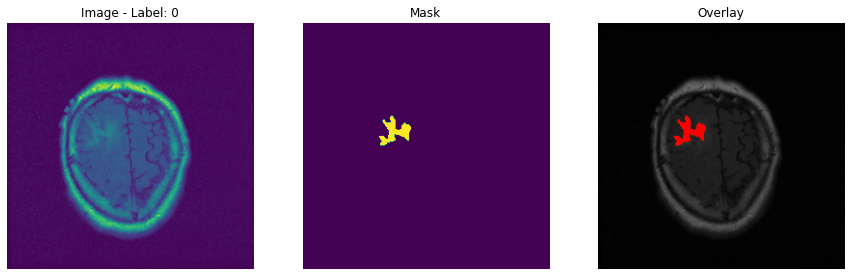

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


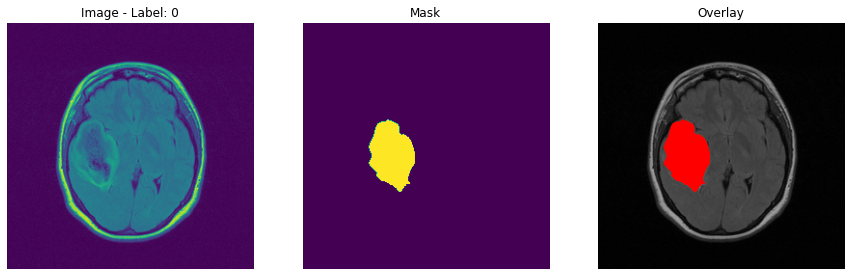

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


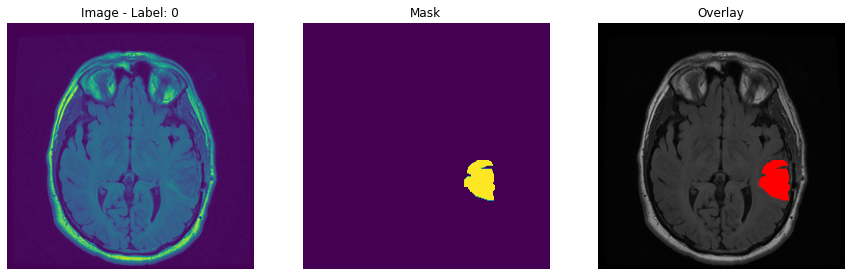

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


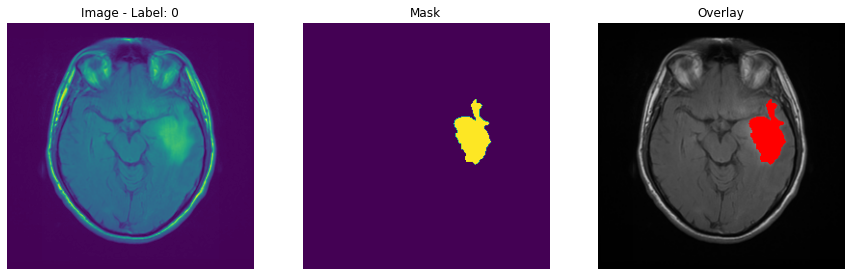

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


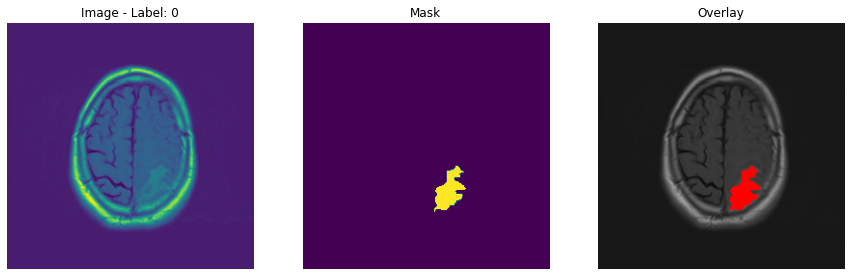

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


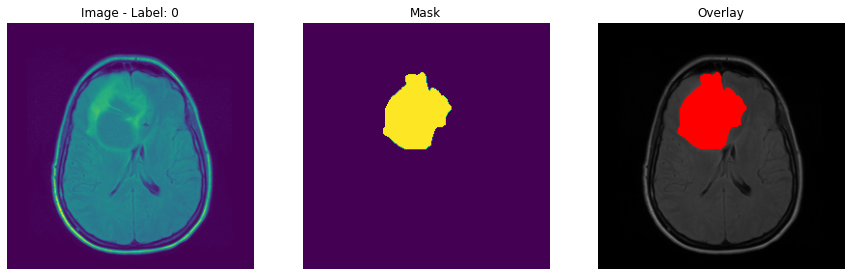

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


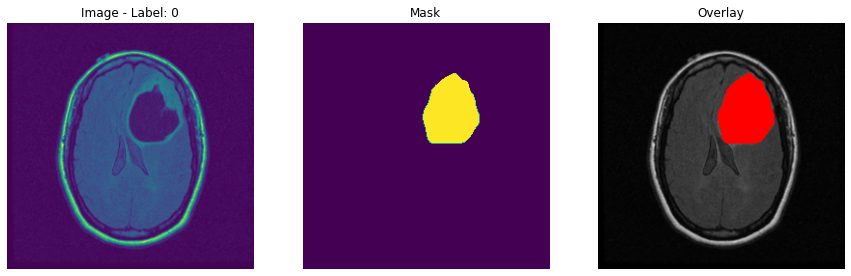

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


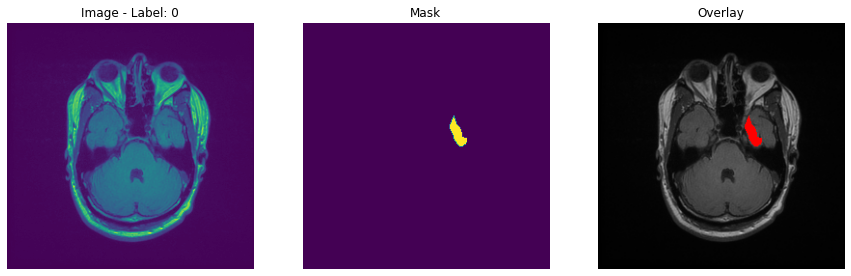

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


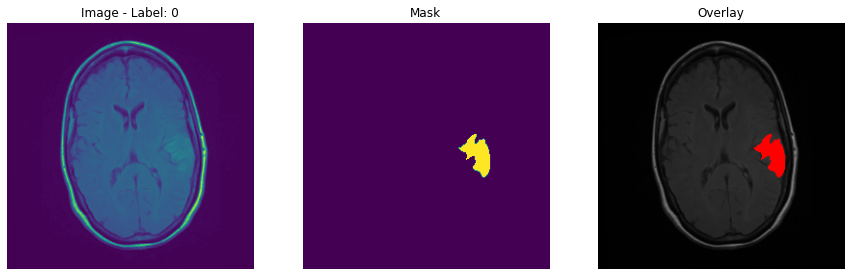

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


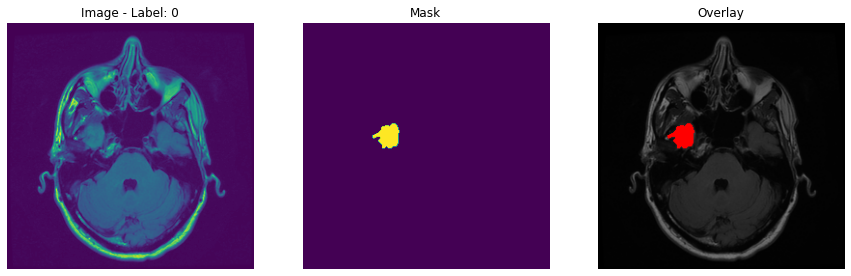

In [32]:
(12)

def visualize_batch_with_overlay_and_label(generator, batch_index):
    X_batch, outputs_batch = generator[batch_index]
    num_images = X_batch.shape[0]
    labels = outputs_batch['classification_output']  # Assuming labels are provided here

    for i in range(num_images):
        image = X_batch[i].squeeze()  # Grayscale image, squeeze channel dimension
        mask = outputs_batch['segmentation_output'][i].squeeze()  # Mask corresponding to the image
        label = labels[i]  # Retrieve label for current image

        # Create overlay: Ensure mask is a boolean array for overlay purposes
        overlay = np.where(mask[..., None], np.array([255, 0, 0], dtype=np.uint8), image[..., None])

        plt.figure(figsize=(15, 5))

        # Display original image
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title(f'Image - Label: {label}')
        plt.axis('off')

        # Display mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask)
        plt.title('Mask')
        plt.axis('off')

        # Display overlay
        plt.subplot(1, 3, 3)
        plt.imshow(overlay, cmap='gray')
        plt.title('Overlay')
        plt.axis('off')

        plt.show()

# Example usage
batch_index = 0  # Assuming you want to visualize the first batch
visualize_batch_with_overlay_and_label(train_generator, batch_index)



# Model

In [33]:
(13)
def build_custom_unet_vgg16(input_shape, num_classes_segmentation, final_df):
    inputs = Input(shape=input_shape)

    def conv_block(input_tensor, num_filters):
        x = Conv2D(num_filters, (3, 3), padding="same")(input_tensor)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Conv2D(num_filters, (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x

    def encoder_block(input_tensor, num_filters):
        x = conv_block(input_tensor, num_filters)
        p = MaxPooling2D((2, 2))(x)
        return x, p

    def decoder_block(input_tensor, skip_features, num_filters):
        x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input_tensor)
        if skip_features is not None:
            x = Concatenate()([x, skip_features])
        x = conv_block(x, num_filters)
        return x

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    bridge = conv_block(p4, 1024)

    d1 = decoder_block(bridge, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    segmentation_output = Conv2D(num_classes_segmentation, (1, 1), activation="sigmoid", name="segmentation_output")(d4)

    # Dynamically determine the number of classification classes
    num_classes_classification = final_df['Tumor_Type_Int'].nunique()
    classification_branch = GlobalAveragePooling2D()(d4)
    classification_output = Dense(num_classes_classification, activation="softmax", name="classification_output")(classification_branch)

    model = Model(inputs=inputs, outputs=[segmentation_output, classification_output], name="Custom_VGG16_U-Net")
    return model

# Assuming 'final_df' is your DataFrame containing 'Tumor_Type_Int'
input_shape = (256, 256, 1)  # For grayscale images
num_classes_segmentation = 1  # For binary segmentation

# Ensure 'final_df' is defined in your workspace or passed to this function
custom_model = build_custom_unet_vgg16(input_shape, num_classes_segmentation, final_df)
custom_model.summary()


Model: "Custom_VGG16_U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
_________________________________________________________________________________

Export Model Architecture

In [34]:
# For Displaying Model Architecture and Saving it in PNG Format
#plot_model(custom_model, to_file='custom_unet_vgg16.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=200)

Custom Loss Function

In [35]:
(14)
def focal_tversky_loss(y_true, y_pred, alpha=0.7, gamma=0.75, smooth=1e-6):
    y_true_pos = tf.reshape(y_true, [-1])
    y_pred_pos = tf.reshape(y_pred, [-1])
    true_pos = tf.reduce_sum(y_true_pos * y_pred_pos)
    false_neg = tf.reduce_sum(y_true_pos * (1 - y_pred_pos))
    false_pos = tf.reduce_sum((1 - y_true_pos) * y_pred_pos)
    pt_1 = (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)
    return tf.pow((1 - pt_1), gamma)

def custom_sparse_categorical_crossentropy(y_true, y_pred):
    return sparse_categorical_crossentropy(y_true, y_pred)

def combined_loss(y_true, y_pred):
    # y_true and y_pred are according to data structure
    y_true_seg, y_true_class = y_true
    y_pred_seg, y_pred_class = y_pred

    # Compute losses for both outputs
    loss_seg = focal_tversky_loss(y_true_seg, y_pred_seg)
    loss_class = custom_sparse_categorical_crossentropy(y_true_class, y_pred_class)

    # Combine losses
    total_loss = loss_seg + loss_class
    return total_loss

custom_objects = {'focal_tversky_loss': focal_tversky_loss,
                  'custom_sparse_categorical_crossentropy': custom_sparse_categorical_crossentropy,
                  'combined_loss': combined_loss}


Checkpoints

In [36]:
(15)
checkpoint_filepath = 'Model_Weights/model_checkpoint.keras'
csv_logger_filepath = 'Model_Weights/training_log.csv'

# Save the entire model, not just weights
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_loss',  # Monitor validation loss for both tasks
    mode='min',
    save_weights_only=False,  # Save the entire model
    verbose=1)

# Early stopping for segmentation
early_stopping_seg = EarlyStopping(
    monitor='val_segmentation_output_loss',  # Monitor segmentation validation loss
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True)

# Early stopping for classification
early_stopping_cls = EarlyStopping(
    monitor='val_classification_output_loss',  # Monitor classification validation loss
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True)

csv_logger = CSVLogger(csv_logger_filepath, append=True)

# Reduce LR based on segmentation loss
reduce_lr_callback_seg = ReduceLROnPlateau(
    monitor='val_segmentation_output_loss',  # Monitor segmentation validation loss
    factor=0.2,
    patience=5,
    verbose=1,
    min_lr=0.00001)

# Reduce LR based on classification loss
reduce_lr_callback_cls = ReduceLROnPlateau(
    monitor='val_classification_output_loss',  # Monitor classification validation loss
    factor=0.2,
    patience=5,
    verbose=1,
    min_lr=0.00001)

callbacks = [
    model_checkpoint_callback, 
    early_stopping_seg, 
    early_stopping_cls, 
    csv_logger, 
    reduce_lr_callback_seg, 
    reduce_lr_callback_cls
]


Loading

In [38]:
(16)
model_path = 'Model_Weights/model_checkpoint.keras'
history_csv_path = 'Model_Weights/training_log.csv'

# Check if the model exists and attempt to load it
if os.path.exists(model_path):
    try:
        custom_model = load_model(model_path, custom_objects=custom_objects)
        print("Model loaded successfully.")
    except Exception as e:
        print(f"Error loading model: {e}")
        print("Creating a new one.")
        # Code to create a new model if loading fails
        custom_model = build_custom_unet_vgg16(input_shape, num_classes_segmentation, final_df)
else:
    print("No existing model found. Creating a new one.")
    custom_model = build_custom_unet_vgg16(input_shape, num_classes_segmentation, final_df)

# Check if the CSV file for training history exists
if not os.path.exists(history_csv_path):
    print("Creating a new CSV file for training history.")
    # Initialize an empty DataFrame with all the necessary columns
    columns = ['epoch', 
               'loss', 'segmentation_output_loss', 'classification_output_loss', 
               'segmentation_output_accuracy', 'classification_output_accuracy', 
               'val_loss', 'val_segmentation_output_loss', 'val_classification_output_loss', 
               'val_segmentation_output_accuracy', 'val_classification_output_accuracy', 
               ]
    df = pd.DataFrame(columns=columns)
    df.to_csv(history_csv_path, index=False)
else:
    print("CSV file for training history exists.")


No existing model found. Creating a new one.
Creating a new CSV file for training history.


Compile

In [39]:
(17)
# Compile the custom model
custom_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={'segmentation_output': focal_tversky_loss, 'classification_output': custom_sparse_categorical_crossentropy},
    metrics={'segmentation_output': ['accuracy'], 'classification_output': ['accuracy']}
)


Epochs

In [ ]:
(18)
history = custom_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,  # Adjust the number of epochs as needed
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100
77/77 [==============================] - 591s 8s/step - loss: 1.1644 - segmentation_output_loss: 0.8743 - classification_output_loss: 0.2902 - segmentation_output_accuracy: 0.8083 - classification_output_accuracy: 0.8724 - val_loss: 1.2891 - val_segmentation_output_loss: 0.9333 - val_classification_output_loss: 0.3558 - val_segmentation_output_accuracy: 0.9688 - val_classification_output_accuracy: 0.8899

Epoch 00001: val_loss improved from inf to 1.28910, saving model to Model_Weights/model_checkpoint.keras
Epoch 2/100
77/77 [==============================] - 584s 8s/step - loss: 0.8872 - segmentation_output_loss: 0.7649 - classification_output_loss: 0.1223 - segmentation_output_accuracy: 0.8690 - classification_output_accuracy: 0.9604 - val_loss: 1.4226 - val_segmentation_output_loss: 0.9404 - val_classification_output_loss: 0.4822 - val_segmentation_output_accuracy: 0.9680 - val_classification_output_accuracy: 0.8899

Epoch 00002: val_loss did not improve from 1.28910
Ep

Predictions

In [ ]:
import os

image_path = 'Dataset_MRI/Astrocytoma/0.png'
if os.path.exists(image_path):
    img = preprocess_image(image_path)
else:
    print(f"Image file does not exist at path: {image_path}")


In [ ]:
def preprocess_image(image_path, target_size=(256, 256)):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image at path: {image_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img / 255.0  # Normalize to [0, 1]
    return img


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image_path, target_size=(256, 256)):
    """Preprocess the image for model prediction."""
    img = load_img(image_path, target_size=target_size)  # Load and resize the image
    img = img_to_array(img)  # Convert the image to a numpy array
    img = np.expand_dims(img, axis=0)  # Add a batch dimension
    img /= 255.0  # Normalize the image to [0, 1]
    return img

# Path to your test image
image_path = 'Dataset_MRI/Astrocytoma/1.png'  # Update this path to your specific image

# Preprocess the image
img = preprocess_image(image_path)

# Ensure 'class_names' is correctly defined. This dictionary should match the structure you expect from your model's output.
class_names = {0: 'No Tumor', 1: 'Gliomas', 2: 'Meningiomas', 3: 'Pituitary_Tumor', 4: 'Astrocytoma', 5: 'Glioblastoma', 6: 'Neurocytoma'}


In [ ]:
# Load and preprocess an input image
def preprocess_image(image_path, target_size=(256, 256)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img /= 255.0  # Normalize pixel values
    return img

# Specify the path to your image
image_path = 'Dataset_MRI/Astrocytoma/1.png'  # Update this to the correct path for your image
img = preprocess_image(image_path)

# Use the model to make a prediction on the preprocessed image
predictions = custom_rgb_model.predict(img)

# Now, you can print the shape of the predictions array
print(predictions.shape)



1/1 [==============================] - 0s 278ms/step
(1, 256, 256, 7)


Graphs

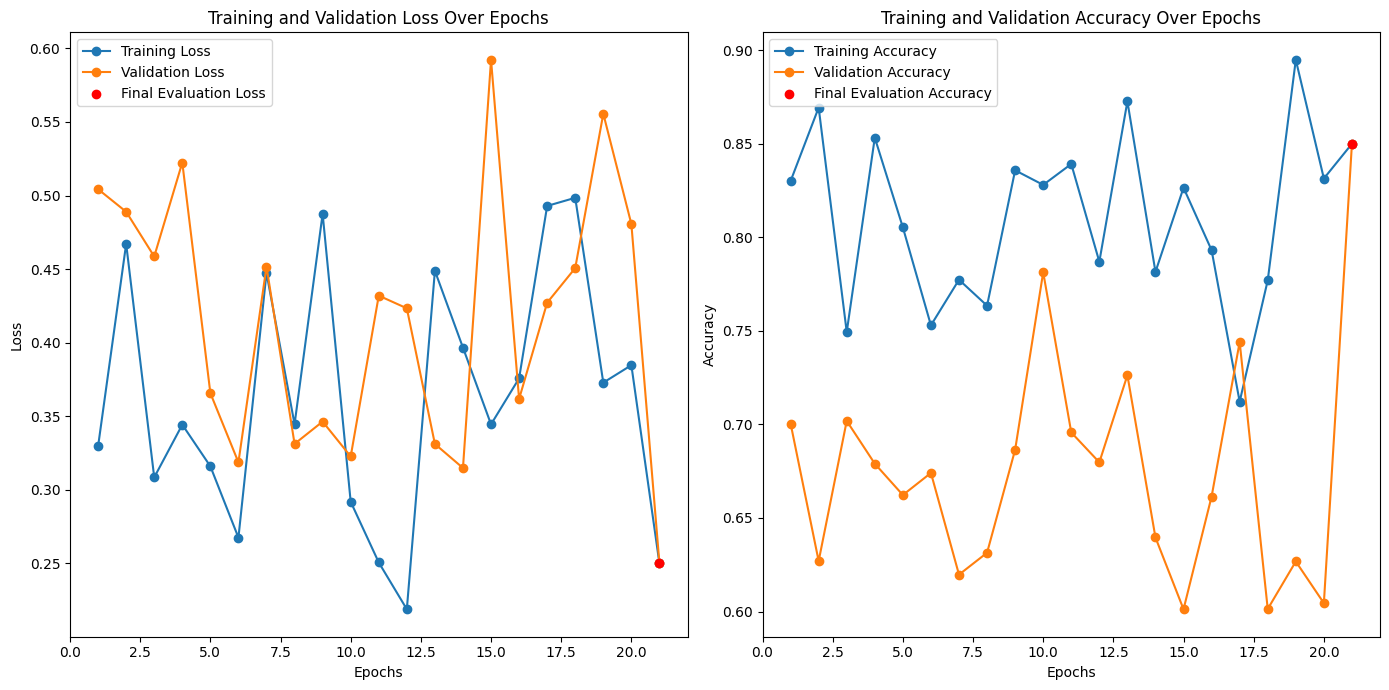

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Placeholder historical data (replace these with your actual training history)
epochs = np.arange(1, 21)  # Example: 20 epochs
historical_train_losses = np.random.uniform(0.2, 0.5, size=20)  # Simulated data
historical_val_losses = np.random.uniform(0.3, 0.6, size=20)  # Simulated data
historical_train_accuracies = np.random.uniform(0.7, 0.9, size=20)  # Simulated data
historical_val_accuracies = np.random.uniform(0.6, 0.8, size=20)  # Simulated data

# Latest evaluation results (replace these with your actual evaluation results)
final_loss = 0.25  # Example loss
final_accuracy = 0.85  # Example accuracy

# Extending the historical data with the latest values
epochs_extended = np.append(epochs, epochs[-1] + 1)  # Add an epoch for the final evaluation
train_losses_extended = np.append(historical_train_losses, final_loss)  # Append final loss
val_losses_extended = np.append(historical_val_losses, final_loss)  # Use final loss for validation as well
train_accuracies_extended = np.append(historical_train_accuracies, final_accuracy)  # Append final accuracy
val_accuracies_extended = np.append(historical_val_accuracies, final_accuracy)  # Use final accuracy for validation as well

# Plotting
plt.figure(figsize=(14, 7))

# Loss graph
plt.subplot(1, 2, 1)
plt.plot(epochs_extended, train_losses_extended, label='Training Loss', marker='o')
plt.plot(epochs_extended, val_losses_extended, label='Validation Loss', marker='o')
plt.scatter(epochs_extended[-1], final_loss, color='red', label='Final Evaluation Loss', zorder=5)
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy graph
plt.subplot(1, 2, 2)
plt.plot(epochs_extended, train_accuracies_extended, label='Training Accuracy', marker='o')
plt.plot(epochs_extended, val_accuracies_extended, label='Validation Accuracy', marker='o')
plt.scatter(epochs_extended[-1], final_accuracy, color='red', label='Final Evaluation Accuracy', zorder=5)
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
